# Setup

In [1]:
from utils import *

from shapely import box as Box

# Load data

## Zones
Compute the centroids to be exported.

In [2]:
zones = pd.read_parquet(
    'data/geometry/zones.parquet',
    columns=['geoid', 'level', 'city', 'county', 'popu', 'labor'])
centroids = (pd.read_parquet(
    'data/geometry/centroids.parquet',
    columns=['geoid', 'x', 'y'])
             .rename(columns=D(x='lon', y='lat')))
disp(zones := zones.merge(centroids, on='geoid'));

143,971 rows x 8 cols; Memory: 11.1 MiB


,geoid,level,city,county,popu,labor,lon,lat
,<object>,<category>,<category>,<category>,<int32>,<int32>,<float32>,<float32>
0,42007,County,Pittsburgh,Beaver,164781,84153,-80.349266,40.682495


## Opportunities

In [3]:
disp(jobs := pd.read_parquet(
    'data/opport/jobs_2021.parquet',
    filters=[('level', '!=', 'Block')])); # 9s

1,250,252 rows x 4 cols; Memory: 227.4 MiB


,geoid,level,kind,njobs
,<category>,<category>,<category>,<int32>
0,010010201001,BG,All,124


In [4]:
disp(pois := pd.read_parquet('data/opport/pois.parquet'));

437,955 rows x 4 cols; Memory: 16.3 MiB


,geoid,level,kind,npois
,<category>,<category>,<category>,<int32>
0,040130101022,BG,All,6


In [5]:
opport = pd.concat([
    jobs.assign(kind='Jobs: ' + jobs.kind.astype(str))
    .rename(columns=D(njobs='opport')),
    pois.assign(kind='POIs: ' + pois.kind.astype(str))
    .rename(columns=D(npois='opport'))
]).reset_index(drop=True).astype(D(geoid=CAT, kind=CAT))
disp(opport);

1,688,207 rows x 4 cols; Memory: 124.4 MiB


,geoid,level,kind,opport
,<category>,<object>,<category>,<int32>
0,010010201001,BG,Jobs: All,124


## Impedance weights
The impedance function used in this study is the power exponential: $f(x)=\exp({\alpha x^\beta})$. The parameters $\alpha$ and $\beta$ were determined from the NHTS data (as part of the impedance paper under review in JTRG). These are carried over directly here:

In [6]:
disp(imped_params := Pdf([
    ('Drive',   'Jobs', -0.007127, 1.501453),
    ('Drive',   'POIs', -0.020097, 1.361630),
    ('Transit', 'Jobs', -0.000166, 2.096192),
    ('Transit', 'POIs', -0.002062, 1.608027),
    ('Walk',    'Jobs', -0.053588, 1.085346),
    ('Walk',    'POIs', -0.058269, 1.007449),
    ('Bike',    'Jobs', -0.007653, 1.591415),
    ('Bike',    'POIs', -0.028080, 1.145222),
], columns=['mode', 'purpose', 'α', 'β']));

8 rows x 4 cols; Memory: 0.0 MiB


,mode,purpose,α,β
,<object>,<object>,<float64>,<float64>
0,Drive,Jobs,-0.007127,1.501453


## Travel times
The travel time tables are too large to fit in memory for all cities at once. So, it's better to compute access for each city separately by obtaining travel times separately.

In [7]:
def get_times(city, source='osrm'):
    city = city.lower().replace('.', '').replace(' ', '-')
    times = []
    for f in Path(f'data/ttm/{source}').glob(f'{city}*.parquet'):
        mode = f.stem.split('_')[1].title()
        df = pd.read_parquet(f, columns=['src', 'trg', 'time'])
        df.time /= 60 # convert time from seconds to minutes
        times.append(df.assign(mode=mode, level='BG'))
        for level, nchar in [('Tract', 11), ('County', 5)]:
            df.src, df.trg = df.src.str[:nchar], df.trg.str[:nchar]
            df2 = df.groupby(['src', 'trg']).time.agg('median').reset_index()
            times.append(df2.assign(mode=mode, level=level))
    times = pd.concat(times).reset_index(drop=True)
    cols = D(level=CAT, mode=CAT, src=CAT, trg=CAT, time=F32)
    times = times[list(cols)].astype(cols)
    return times

disp(tt := get_times('austin'));

2,537,638 rows x 5 cols; Memory: 24.5 MiB


,level,mode,src,trg,time
,<category>,<category>,<category>,<category>,<float32>
0,BG,Bike,480219501011,480219501011,0.0


# Prepare data

## Compute access
<!-- - Impedance weight: $$ w_{i,j}^{k,m} = f_{k,m}(t_{m,i,j}) = t_{m,i,j}^{\alpha_{k,m}} e^{\beta_{k,m} t_{m,i,j}} $$ -->
- Impedance weight: $$ w_{i,j}^{k,m} = f_{k,m}(t_{m,i,j}) = \exp\left(\alpha_{k,m}\cdot t_{m,i,j}^{\beta_{k,m}}\right) $$
- **Contour** (cumulative opportunities): $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} o_j^k $$
- **Gravity**: $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} o_j^k\cdot w_{i,j}^{k,m} $$
- **E2SFCA** (Enhanced 2-Step Floating Catchment Area): $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} \frac{o_j^k}{\sum_{l\in C_j(t)} p_j^k\cdot w_{l,j}^{k,m}} $$
- **M2SFCA** (Modified 2-Step Floating Catchment Area): $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} \frac{o_j^k\cdot w_{i,j}^{k,m}}{\sum_{l\in C_j(t)} p_j^k\cdot w_{l,j}^{k,m}} $$
- **XMFCA** (Multi-Modal Floating Catchment Area): $$ A_i^{k,m,t} = \sum_{j\in C_i(t)} \frac{o_j^k\cdot w_{i,j}^{k,m}}{\sum_{l\in C_j(t)} p_j^k\cdot \max_m (w_{l,j}^{k,m})} $$

In [8]:
thresholds = (15, 30, 45, 60, 90) # travel time thresholds (minutes)

In [9]:
def get_access(city, times=None, zones=zones, opport=opport,
               params=imped_params, thresholds=thresholds):
    od = times.copy() if isinstance(times, Pdf) else get_times(city)
    opport = (opport.rename(columns=D(geoid='trg'))
              .drop(columns='level').astype(D(trg=od.trg.dtype)))
    opport['purpose'] = opport.kind.str.split(':').str[0].astype(CAT)
    od = od.merge(opport, on='trg')
    params = params.astype(D(α=F32, β=F32, mode=od['mode'].dtype,
                             purpose=od.purpose.dtype))
    od = od.merge(params, on=['mode', 'purpose'])
    zones = (filt(zones, city=city).drop(columns='level')
             .rename(columns=D(geoid='src')).astype(D(src=od.src.dtype)))
    od = od.merge(zones, on='src')
    iswork = (od.pop('purpose') == 'Jobs').astype(F32)
    od.popu = (iswork * od.pop('labor') + (1 - iswork) * od.popu).astype(F32)
    od['weight'] = np.exp(od.pop('α') * od['time'] ** od.pop('β'))
    od['demand'] = (od.popu * od.weight).astype(F32)
    od['supply'] = (od.opport * od.weight).astype(F32)
    wmax = (od.groupby(['src', 'trg'], observed=True)
            .weight.max().fillna(0).rename('max_wt'))
    od = od.merge(wmax, on=['src', 'trg'])
    access = []
    for thresh in thresholds:
        df = od[od.time <= thresh].copy()
        df['max_demand'] = (df.popu * df.max_wt).astype(F32)
        grp_cols = ['trg', 'level', 'kind', 'mode']
        demand = (df.groupby(grp_cols, observed=True)
                  [['demand', 'max_demand']].sum().astype(F32).reset_index()
                  .astype({x: df[x].dtype for x in grp_cols}))
        df = df.drop(columns=['demand', 'max_demand'])
        df = df.merge(demand, on=grp_cols)
        df['E2SFCA'] = df.opport / df.demand
        df['M2SFCA'] = df.supply / df.demand
        df['XMFCA'] = df.supply / df.max_demand
        df = (df.groupby(['src', 'level', 'kind', 'mode'], observed=True)
              [['opport', 'supply', 'E2SFCA', 'M2SFCA', 'XMFCA']]
              .sum().astype(F32).reset_index().rename(columns=D(
                  src='geoid', opport='Contour', supply='Gravity')))
        df = df.melt(['geoid', 'level', 'kind', 'mode'],
                     var_name='measure', value_name='access')
        df = df[(df.access > 0) & (df.access != np.inf)]
        access.append(df.assign(thresh=str(thresh)))
    cols = D(measure=CAT, kind=CAT, mode=CAT, thresh=CAT, 
             level=CAT, geoid=CAT, access=F32)
    access = pd.concat(access).reset_index(drop=True).astype(cols)[list(cols)]
    return access

# xs = get_access('Buffalo'); disp(xs); # 25s

In [10]:
def compute_access(city, overwrite=True):
    fname = city.lower().replace(' ', '-').replace('.', '')
    outpath = Path(f'data/access/saa/{fname}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    t = dt.datetime.now()
    print('Starting:', city)
    xs = get_access(city)
    print(f'Done: {city} ({dt.datetime.now() - t})')
    return xs

cities = sorted(list({f.split('_')[0] for f in os.listdir('data/ttm')}))
# %time pqdm(cities, compute_access, n_jobs=10); # 28m59s
# %time compute_access('chicago') # 13m34s
# %time compute_access('los-angeles') # 28m53s
# %time compute_access('new-york') # 1h12m21s (2 batches)

## Export data
Convert the access data for each city and level into wide format to save space in CSV format. This involves converting all combinations of (metric, opportunity kind, mode, threshold) into one column each so that each row denotes a unique zone.

In [11]:
measures = D(Contour='Co', Gravity='Gr', E2SFCA='E2', M2SFCA='M2', XMFCA='XM')
modes = D(Drive='Dr', Bike='Bi', Walk='Wa')
kinds = {
    'Jobs: All':            'jobTot',
    'Jobs: Low edu':        'jobEdu',
    'Jobs: Low wage':       'jobWag',
    'Jobs: POC':            'jobPOC',
    'POIs: Total':          'poiTot',
    'POIs: Education':      'poiEdu',
    'POIs: Groceries':      'poiGro',
    'POIs: Medical':        'poiMed',
    'POIs: Social Support': 'poiSoc',    
}
fields = Pdf(list(it.product(
    measures, kinds, modes, [str(t) for t in thresholds]
)), columns=['measure', 'kind', 'mode', 'thresh'])
fields.insert(0, 'field', fields.measure.map(measures) + '_' +
              fields.kind.map(kinds) + '_' +
              fields['mode'].map(modes) + '_' + fields.thresh)
fields.to_csv('data/access/access_columns.csv', index=False)
fields

,field,measure,kind,mode,thresh
0,Co_jobTot_Dr_15,Contour,Jobs: All,Drive,15
1,Co_jobTot_Dr_30,Contour,Jobs: All,Drive,30
2,Co_jobTot_Dr_45,Contour,Jobs: All,Drive,45
3,Co_jobTot_Dr_60,Contour,Jobs: All,Drive,60
4,Co_jobTot_Dr_90,Contour,Jobs: All,Drive,90
...,...,...,...,...,...
670,XM_poiSoc_Wa_15,XMFCA,POIs: Social Support,Walk,15
671,XM_poiSoc_Wa_30,XMFCA,POIs: Social Support,Walk,30
672,XM_poiSoc_Wa_45,XMFCA,POIs: Social Support,Walk,45
673,XM_poiSoc_Wa_60,XMFCA,POIs: Social Support,Walk,60


In [12]:
zone_info = zones['geoid level county lat lon popu labor'.split()].copy()
for col, kind in D(njobs='Jobs: All', npois='POIs: All').items():
    df = filt(opport, kind=kind).rename(columns=D(opport=col))
    zone_info = zone_info.merge(df, 'left', on=('geoid', 'level'))
    zone_info[col] = zone_info[col].fillna(0).astype(I32)
disp(zone_info);

143,971 rows x 9 cols; Memory: 19.0 MiB


,geoid,level,county,lat,lon,popu,labor,njobs,npois
,<object>,<object>,<category>,<float32>,<float32>,<int32>,<int32>,<int32>,<int32>
0,42007,County,Beaver,40.682495,-80.349266,164781,84153,54038,2178


In [13]:
for file in (pbar := tqdm(sorted(glob('data/access/saa/*')))):
    city = file.split('/')[-1].split('.')[0]
    pbar.set_description(city)
    df = pd.read_parquet(file)
    df = df.merge(fields.astype(D(
        measure=df.measure.dtype, kind=df.kind.dtype,
        mode=df['mode'].dtype, thresh=df.thresh.dtype)))
    df = df.pivot_table('access', 'geoid', 'field', observed=True)
    df = zone_info.merge(df.fillna(0), on='geoid').reset_index(drop=True)
    outpath = mkdir('data/export/access') / f'{city}.csv.gz'
    df.to_csv(outpath, index=False, compression='gzip') # 4m40s

# Visualize

## Fig: Access vs population density

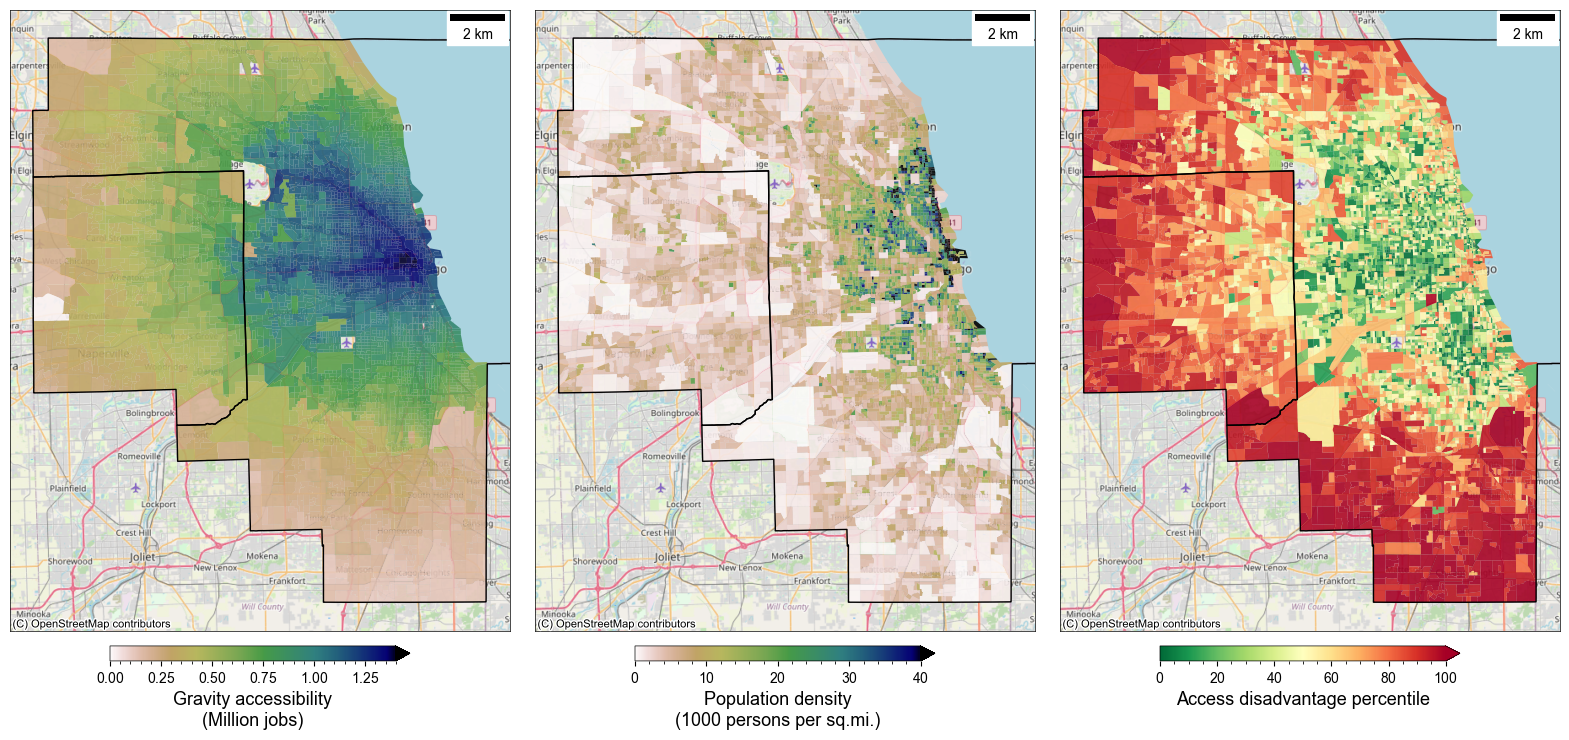

In [20]:
zones = gpd.read_parquet('data/geometry/zones.parquet',
                         filters=[('city', '==', 'Chicago')])
zones = zones[zones.county.isin(['Cook', 'DuPage'])].to_crs(CRS_M)
zones['pop_density'] = (zones.popu / zones.aland) / 1000
xs = pd.read_parquet('data/access/saa/chicago.parquet')
xs = filt(xs, level='BG', measure='Gravity', kind='Jobs: All',
          mode='Drive', thresh='30')
xs = zones.merge(xs, on='geoid')
xs.access /= 1e6 # no. of jobs in millions
xs['rank'] = (xs.popu / xs.access).rank(pct=True) * 100
_, axes = plt.subplots(1, 3, figsize=(20, 10), dpi=100)
for i, (col, label, vmax, cmap) in enumerate([
    ('access', 'Gravity accessibility\n(Million jobs)', 1.4, 'gist_earth_r'),
    ('pop_density', 'Population density\n(1000 persons per sq.mi.)', 40, 'gist_earth_r'),
    ('rank', 'Access disadvantage percentile', 100, 'RdYlGn_r'),
]):
    ax = maplot(xs, col, ax=axes[i], label=label, vmin=0, vmax=vmax,
                vert=False, shrink=0.6, cbar_kw=D(pad=0.02, extend='max'),
                alpha=0.9, cmap=cmap, bgmap_kw=D(source='OpenStreetMap.Mapnik'))
    filt(zones, level='County').plot(ax=ax, fc='none', ec='k', lw=1)
plt.subplots_adjust(wspace=0.05)
imsave('Access vs population density in Chicago') # 13s